In [1]:
import numpy as np
#
# The function in this file follow closely after the MATLAB scripts
# written by Alessandro Foi and Markku Makitalo - Tampere University
# of Technology - 2011-2012
#
#    http://www.cs.tut.fi/~foi/invansc/
#
# that accompanies their paper:
#
#    Reference: M. Makitalo and A. Foi, "Optimal inversion of the
#    generalized Anscombe transformation for Poisson-Gaussian noise",
#    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675


#-------- Variance stabilizing transforms -----------

def anscombe(x):
    '''
    Compute the anscombe variance stabilizing transform.
      the input   x   is noisy Poisson-distributed data
      the output  fx  has variance approximately equal to 1.
    Reference: Anscombe, F. J. (1948), "The transformation of Poisson,
    binomial and negative-binomial data", Biometrika 35 (3-4): 246-254
    '''
    return 2.0*np.sqrt(x + 3.0/8.0)

def inverse_anscombe(z):
    '''
    Compute the inverse transform using an approximation of the exact
    unbiased inverse.
    Reference: Makitalo, M., & Foi, A. (2011). A closed-form
    approximation of the exact unbiased inverse of the Anscombe
    variance-stabilizing transformation. Image Processing.
    '''
    #return (z/2.0)**2 - 3.0/8.0
    return (1.0/4.0 * np.power(z, 2) +
            1.0/4.0 * np.sqrt(3.0/2.0) * np.power(z, -1.0) -
            11.0/8.0 * np.power(z, -2.0) + 
            5.0/8.0 * np.sqrt(3.0/2.0) * np.power(z, -3.0) - 1.0 / 8.0)

def generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Compute the generalized anscombe variance stabilizing transform,
    which assumes that the data provided to it is a mixture of poisson
    and gaussian noise.
    The input signal  z  is assumed to follow the Poisson-Gaussian noise model
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    We assume that x contains only positive values.  Values that are
    less than or equal to 0 are ignored by the transform.
    Note, this transform will show some bias for counts less than
    about 20.
    '''
    y = gain*x + (gain**2)*3.0/8.0 + sigma**2 - gain*mu

    # Clamp to zero before taking the square root.
    return (2.0/gain)*np.sqrt(np.maximum(y, 0.0))

def inverse_generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Applies the closed-form approximation of the exact unbiased
    inverse of Generalized Anscombe variance-stabilizing
    transformation.
    The input signal x is transform back into a Poisson random variable
    based on the assumption that the original signal from which it was
    derived follows the Poisson-Gaussian noise model:
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    Roference: M. Makitalo and A. Foi, "Optimal inversion of the
    generalized Anscombe transformation for Poisson-Gaussian noise",
    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675
    '''
    test = np.maximum(x, 1.0)
    exact_inverse = ( np.power(test/2.0, 2.0) +
                      1.0/4.0 * np.sqrt(3.0/2.0)*np.power(test, -1.0) -
                      11.0/8.0 * np.power(test, -2.0) +
                      5.0/8.0 * np.sqrt(3.0/2.0) * np.power(test, -3.0) -
                      1.0/8.0 - np.power(sigma, 2) )
    exact_inverse = np.maximum(0.0, exact_inverse)
    exact_inverse *= gain
    exact_inverse += mu
    exact_inverse[np.where(exact_inverse != exact_inverse)] = 0.0
    return exact_inverse

#def inverse_generalized_anscombe(y,mu,sigma,gain=1.0):
#    return (1.0/gain)*(gain*y/2.0)**2 - gain*3.0/8.0 - (sigma**2)/gain + mu

In [2]:
from bm3d import bm3d, BM3DProfile
import numpy as np
import scipy.misc
from matplotlib import pyplot as plt
from tifffile import imread, imsave

In [3]:
noisy = imread('../../../experiments/fairSim/2020-07-27/Zeiss/p0/Zeiss_Mito_600nm_crop_Poisson-n0.tif').astype(np.float32)

clean = imread('../../../experiments/fairSim/2020-07-27/Zeiss/Zeiss_Mito_600nm_crop.tif').astype(np.float32)
print(noisy.shape)
print(clean.shape)


(5, 25, 512, 512)
(5, 25, 512, 512)


In [4]:
offset=100
from tqdm import tqdm
mses=[]
denoisedImgs=[]
bestMSE = None
bestImg = None
bestSig= None

for s in range(40):
    sig = (s+1)*2.5
    #denoised=noisy.copy()
    j=0
    #for i in range(5):
    i=0
#        print(i,j)

    img=noisy[i,j,...]
    cl= clean[i,j,...]

        
    ans=anscombe(img-offset)
    denoised = inverse_anscombe (bm3d (ans,sig)) + offset
    
        
    mse = np.mean((cl-denoised)**2)
    mses.append(mse)
    denoisedImgs.append(denoised.copy())
    
    if bestMSE is None or (mse<bestMSE):
        bestImg = denoised.copy()
        bestMSE = mse
        bestSig = sig
    print (sig, bestSig, mse)

        

2.5 2.5 23122.389666781048
5.0 5.0 10757.582625402847
7.5 7.5 3560.899404155024
10.0 10.0 3377.3331319392178
12.5 10.0 3498.681578541278
15.0 10.0 3683.464143898233
17.5 10.0 3914.996449478952
20.0 10.0 4164.941038987
22.5 10.0 4434.025003263313
25.0 10.0 4711.588042602958
27.5 10.0 4992.589010067078
30.0 10.0 5267.4019139178
32.5 10.0 5557.95380423931
35.0 10.0 5840.15824229298
37.5 10.0 6124.534056119397
40.0 10.0 6411.404067860765
42.5 10.0 6697.46201469748
45.0 10.0 6982.254082770524
47.5 10.0 7262.937299512161
50.0 10.0 7540.91684393948
52.5 10.0 7812.491964024174
55.0 10.0 8088.765447426866
57.5 10.0 8361.029912934704
60.0 10.0 8623.731641294871
62.5 10.0 8876.471363391025
65.0 10.0 9129.849376881617
67.5 10.0 9378.169658910008
70.0 10.0 9621.91302352258
72.5 10.0 9858.983086934524
75.0 10.0 10090.69213265648
77.5 10.0 10320.700242525145
80.0 10.0 10550.366119938812
82.5 10.0 10778.995337733615
85.0 10.0 11004.500494339032
87.5 10.0 11227.990607525822
90.0 10.0 11455.334291485517

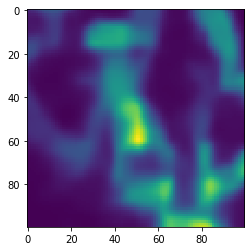

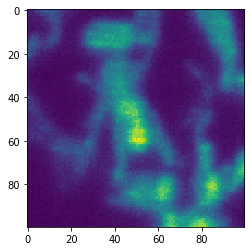

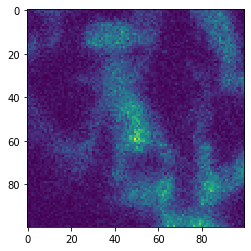

In [5]:
plt.imshow(denoisedImgs[11][100:200,100:200])
plt.show()
plt.imshow(cl[100:200,100:200])
plt.show()
plt.imshow(img[100:200,100:200])


In [6]:
offset=100
from tqdm import tqdm
denoised=noisy.copy()

for j in tqdm(range(25)):
    for i in range(5):
        img=noisy[i,j,...]
        cl= clean[i,j,...]

        sig = bestSig

        ans=anscombe(img-offset)
        denoisedImg = inverse_anscombe (bm3d (ans,sig)) + offset
        denoised[i,j,...] = denoisedImg
    


imsave('../../../experiments/fairSim/2020-07-27/Zeiss/p0/n0_VST-BM3D.tif', denoised)
        

100%|██████████| 25/25 [1:04:29<00:00, 154.80s/it]
